# Assignment 10 - Example Applications (32 Points Total)
<span style='color:red'> Due date: 20.07.2021 23:59 &nbsp;&nbsp;&nbsp;&nbsp;<font size=5>This assignment is <em>optional</em>!</font> &nbsp;&nbsp;&nbsp;&nbsp; The points still count towards your balance.</span> 

This week's assignment is about two example applications. If anything is unclear or if you find errors, feel free to post in the forum set up in Ilias or ask in the WebEx live session, or write an email to one of us.

_You can submit incomplete assignments that don't validate_. If a test cell validates correctly, you will get the points. If test cells don't validate, you may still get at least partial points.

## Surrogate Modeling (13 points)
A simple but useful way to employ artificial neural networks is *surrogate modeling*. This can be done with data from simulations or from experiments. Here, we'll look at the procedure for data derived from a simulation. The example simulation is a very simple 1D heat diffusion problem.

The code below implements a Crank-Nicolson scheme for heat conduction along a truss (no guarantee on this being correct). The results are computed on a grid of spatial discretization points (we'll restrict ourselves to 5 nodes here) and temporal discretization points (using the square of the number of spatial discretization points here). The inputs to the solver below are the number of spatial discretization points `N`, the total simulation time `T`, the length of the beam `L`, the thermal conductivity `α_c`, and the left and right Dirichlet boundary conditions (prescribed temperatures) `lbc` and `rbc`. `lbc` is taken as a starting temperature and hence applied to all nodes.

In [4]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

def cn_heat(N_x, T, L, α_c, lbc, rbc):
    """ N_x: number of spatial grid points
        T:   total simulation time
        L:   truss length
        α_c: thermal conductivity
        lbc: boundary condition on left node
        rbc: boundary condition on right node
    """
    # number of temporal grid points
    N_t = (N_x**2) 

    # positions
    x_0, x_L = 0, L
    # temporal "positions"
    t_0, t_T = 0, T 

    # nodal distance
    dx = (x_L - x_0)/(N_x - 1)
    # time step
    dt = (t_T - t_0)/(N_t - 1)

    # make PDE dimensionless
    λ = dt*α_c/(2.0*dx**2)
    c1 = 1 + 2*λ
    c2 = 1 - 2*λ

    # create grids
    x_grid = np.linspace(x_0, x_L, N_x)
    t_grid = np.linspace(t_0, t_T, N_t)
    # create stiffness matrices
    maindiag_c1 = c1*np.ones((1,N_x))
    offdiag_c1 = (-λ)*np.ones((1, N_x-1))

    maindiag_c2 = c2*np.ones((1,N_x))
    offdiag_c2 = λ*np.ones((1, N_x-1))

    # left tridiagonal matrix
    a = maindiag_c1.shape[1]
    diagonalsA = [maindiag_c1, offdiag_c1, offdiag_c1]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    
    A[0,1] = -2 * λ
    A[N_x-1,N_x-2] = -2 * λ

    # right tridiagonal matrix
    c = maindiag_c2.shape[1]
    diagonalsC = [maindiag_c2, offdiag_c2, offdiag_c2]
    
    A_right = sparse.diags(diagonalsC, [0,-1,1], shape=(c,c)).toarray()
    A_right[0,1] = 2*λ
    A_right[N_x-1,N_x-2] = 2*λ

    # initialize "displacements", will contain temperatures themselves
    U = np.zeros((N_x, N_t))

    # initial conditions (Dirichlet)
    # all nodes are at temperature lbc K
    U[:,0]  = lbc
    # the last node is assigned a temperature rbc K
    U[-1,0] = rbc
    #U[:,1] = 2

    # initial conditions (Neumann), all set to 0 here
    LBC = np.arange(1, N_t+1)
    f = np.array([0 for leftbc in LBC])

    RBC = np.arange(1, N_t+1)
    g = np.array([0 for rightbc in RBC])

    # assemble and solve LES for each time step
    for k in range(1, N_t):
        ins = np.zeros((N_x-2,1)).ravel()
        # Neumann bcs
        b1 = np.asarray([4*λ*dx*f[k], 4*λ*dx*g[k]])
        b1 = np.insert(b1, 1, ins)
        # Dirichlet bcs
        b2 = np.matmul(A_right, np.array(U[0:N_x, k-1]))
        b = b1 + b2 
        # solve LES and get displacements
        U[0:N_x, k] = np.linalg.solve(A,b)
    
    return [U, t_grid, x_grid]


def plot_heat(sol):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    
    axs[0].plot(sol[2], sol[0])
    axs[0].set_title("Thermal Development over Length")
    axs[0].set_xlabel(r"$x$ [cm]")
    axs[0].set_ylabel(r"$\theta$ [K]")
    axs[0].legend(["time " + str(t) for t in range(sol[0].shape[1])], ncol=3)
    
    axs[1].plot(sol[1], sol[0].T)
    axs[1].set_title("Thermal Development over Time")
    axs[1].set_xlabel(r"$t$ [s]")
    axs[1].set_ylabel(r"$\theta$ [K]")
    axs[1].legend(["node " + str(n) for n in range(sol[0].shape[0])])
    
    g = np.meshgrid(sol[1], sol[2])
    
    cs = axs[2].contourf(*g, sol[0], levels=20)
    axs[2].set_title(r"Temporal Change of $\theta$ on all Nodes")
    axs[2].set_xlabel(r"$t$ [s]")
    axs[2].set_ylabel(r"$x$ [cm]")
    #axs[2].colorbar()
    
    cbar = fig.colorbar(cs)
    
    plt.tight_layout()
    

Below is an example of how to call and use this function:

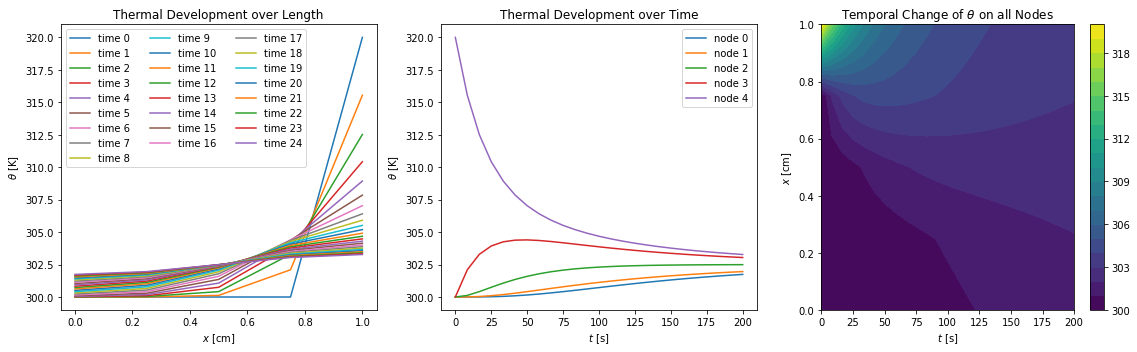

In [5]:
sol = cn_heat(5, 200, 1, 0.001, 300, 320)

plot_heat(sol)

On the left you see the thermal development at each node (each position in the truss where measurements are available) for all time steps. In the beginning, only the last node has an assigned temperature (the boundary condition), while the others are at $0$ (of course this is unphysical, but let's just use this as an example). In the middle, the thermal development over time for each node is plotted. The node with assigned heat cools down, while neighboring nodes warm up until at some point an equilibrium is reached.

Let's think about the features in our system and the solutions we need to create a surrogate model. Here, we restrict ourselves to using 5 nodes in the system (and 25 temporal grid points) for the discretization. The remaining parameters are the total simulation time `T` and the thermal conductivity `α_c`, so we'll use these as features. We could also use the left and right boundary conditions as features, but creating the necessary data would then take much longer. 

The boundaries for which we'll generate training data here are $T \in [1, 100]\,$s and $\alpha_c \in [0.001, 0.1]\,\frac{\text{W}}{\text{Km}}$. The following code takes a few minutes to execute:

In [6]:
# data generation, using T and α_c
features  = []
solutions = []

for T in range(1, 101):
    for α_c_inv in range(10, 1001):
        features.append([T, 1/α_c_inv])
        solutions.append(cn_heat(5, T, 1, 1/α_c_inv, 300, 320)[0])

Let's see how much data we have and generally check the tensor dimensions:

In [7]:
from sys import getsizeof

# numpy arrays are always easier to handle
features = np.array(features)
solutions = np.array(solutions)

print(features.shape)
print(solutions.shape)

print("Size of features:   " + str(round(getsizeof(features )/2**20, 1)) + " MiB")
print("Size of solutions: " + str(round(getsizeof(solutions)/2**20, 1)) + " MiB")

(99100, 2)
(99100, 5, 25)
Size of features:   1.5 MiB
Size of solutions: 94.5 MiB


For a standard ANN, we need an input layer accepting the chosen 2 input features and an output layer producing $5*25 = 125$ values, one for each grid point in the simulation (this could also be a finite element mesh for example). The following cell reshapes the solutions to fit such an architecture:

In [8]:
X = features
y = solutions.reshape([solutions.shape[0], solutions.shape[1]*solutions.shape[2]])

print(X.shape)
print(y.shape)

(99100, 2)
(99100, 125)


We should also normalize the features and targets:

In [9]:
from sklearn.preprocessing import MinMaxScaler

# instantiate scaler objects for each array
# these retain their state, so that you can later undo
# the transformation
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# fit_transform "fits" the scalers to the data, so that they know the
# minimum and maximum in this case, then applies the transformation
X_s = X_scaler.fit_transform(X)
y_s = y_scaler.fit_transform(y)

Now, the ANN needs to be built. Fill in the blanks below:

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

K.clear_session()

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# create a sequential model called "surrogate" here
# add a Dense layer with 30 neurons
# and appropriate input_dim, activation 'relu'. 
# add a second Dense layer with 30 neurons and 'relu' activation.
# add a Dense output layer with appropriate number of neurons and
# 'linear' activation
# then, compile the model with 'adam' optimizer and appropriate
# loss function, and one of the metrics defined above. Which one
# makes sense here?
### BEGIN SOLUTION
surrogate = Sequential()

surrogate.add(Dense(30, input_dim=X.shape[1], activation='relu'))
surrogate.add(Dense(30, activation='relu'))
surrogate.add(Dense(125, activation='linear'))

surrogate.compile(optimizer='adam', loss='mse', metrics=[r2_score])
### END SOLUTION

Now that the model is set up, it needs to be trained. Do so below with 10 `epochs` and a `validation_split` of 0.3. Note that we haven't generated test data here. This is possible and would be a more sensible approach, but for brevity's sake we'll use the simulation itself to see how good our results are. You already know how to do a history graph to see overfitting and other problems, so we'll omit this here. For your own tests, try doing the training without normalizing the training data beforehand to see what happens. 

In [30]:
# fit the model to X and y with the arguments mentioned above
# save the results in a variable valled "surrogate_history"
### BEGIN SOLUTION
surrogate_history = surrogate.fit(X_s, y_s, epochs=15, validation_split=0.3)
### END SOLUTION

Epoch 1/15
2168/2168 [==============================] - 6s 2ms/step - loss: 0.0495 - r2_score: 0.6116 - val_loss: 0.0089 - val_r2_score: 0.9278
Epoch 2/15
2168/2168 [==============================] - 5s 2ms/step - loss: 0.0023 - r2_score: 0.9821 - val_loss: 0.0068 - val_r2_score: 0.9437
Epoch 3/15
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0012 - r2_score: 0.9908 - val_loss: 0.0072 - val_r2_score: 0.9396
Epoch 4/15
2168/2168 [==============================] - 5s 2ms/step - loss: 7.5767e-04 - r2_score: 0.9940 - val_loss: 0.0064 - val_r2_score: 0.9470
Epoch 5/15
2168/2168 [==============================] - 5s 2ms/step - loss: 5.8905e-04 - r2_score: 0.9954 - val_loss: 0.0057 - val_r2_score: 0.9529
Epoch 6/15
2168/2168 [==============================] - 5s 2ms/step - loss: 4.6867e-04 - r2_score: 0.9963 - val_loss: 0.0052 - val_r2_score: 0.9572
Epoch 7/15
2168/2168 [==============================] - 4s 2ms/step - loss: 3.7270e-04 - r2_score: 0.9971 - val_loss: 0.0048

Let's quickly look at the loss and metric plots:

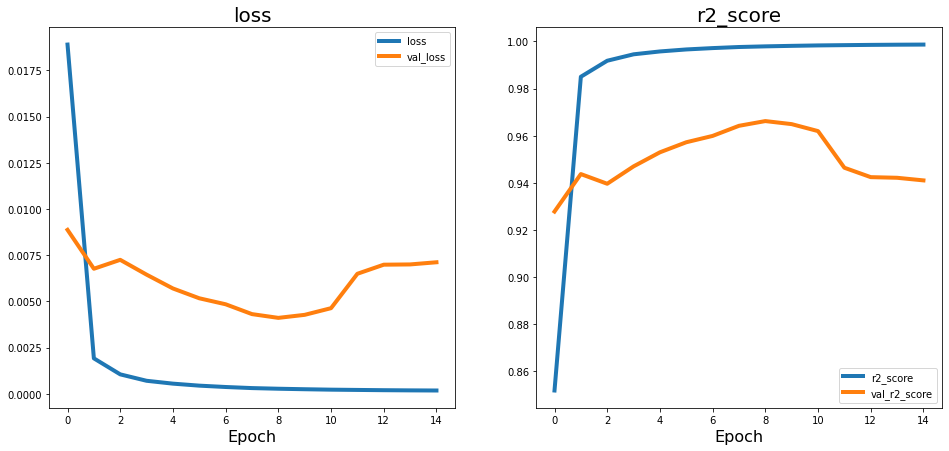

In [40]:
fig,axs = plt.subplots(1,2, figsize=(16,7))

for i,key in enumerate(surrogate_history.history.keys()):
    axs[i%2].set_title(key[4:], fontsize=20)
    axs[i%2].plot(surrogate_history.history[key], lw=4, label=key)
    axs[i%2].set_xlabel("Epoch", fontsize=16)
    axs[i%2].legend()


The idea of a surrogate model is to be able to make predictions for cases that the simulation did not run for. The code below compares such an untrained prediction to the results of the real simulation.

################ Ground Truth ################
############### ANN Prediction ###############


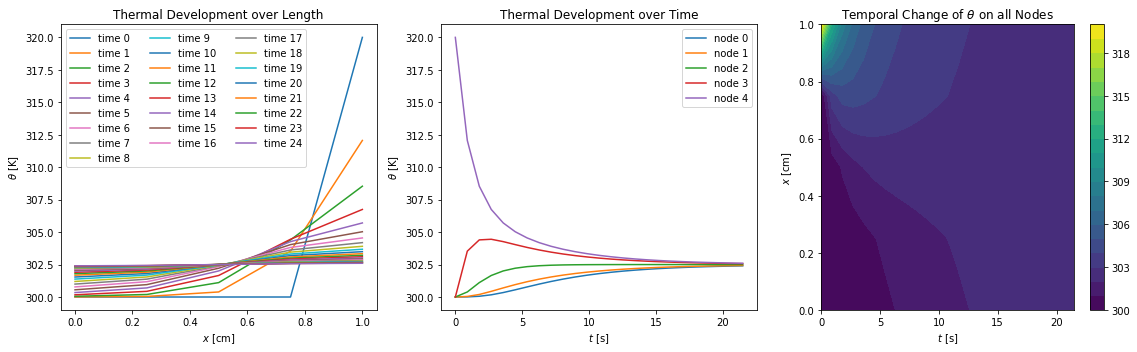

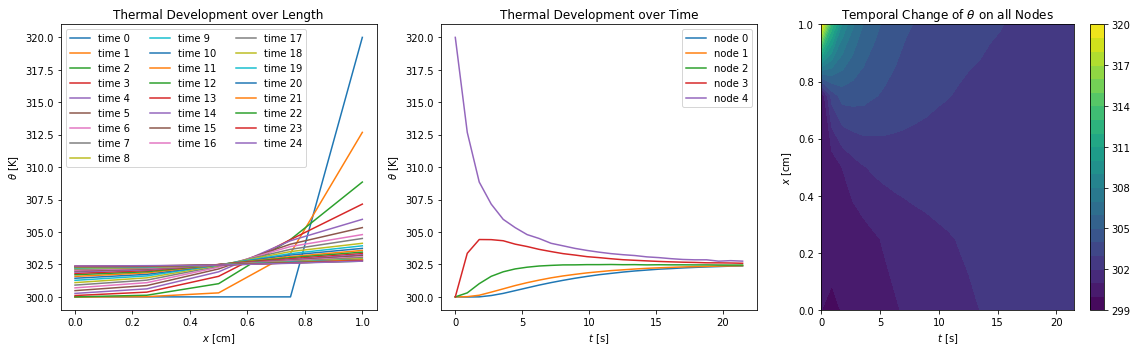

In [41]:
# use the surrogate model to predict heat convection in the system 
# for T = 21.5 and α_c = 1/51.5
# first, define a variable called "testinput" that contains the
# transformed version of T and α_c, which you can do almost like 
# before, when we scaled all the features. Here, call the 
# "transform" method of the X_scaler on an array of T and α_c
### BEGIN SOLUTION
test_input = X_scaler.transform(np.array([[21.5, 1/51.5]]))
pred_s = surrogate.predict([test_input])
### END SOLUTION

# undo the scaling of outputs and reshape to grid format
pred = y_scaler.inverse_transform(pred_s).reshape([5, 25])

# create the ground truth from the simulation
gt = cn_heat(5, 21.5, 1, 1/51.5, 300, 320)

print("################ Ground Truth ################")
plot_heat(gt)
print("############### ANN Prediction ###############")
plot_heat([pred, gt[1], gt[2]])

This is far from being a fantastic model, but you should be able to see correspondences. Since this produces sequential data, an LSTM probably performs even better than this.

You can't really see how well the prediction above worked, so it's good practice to also produce an *error plot*. Usually, this is done over the whole *test set* (take the mean and standard devation and plot both), but for demonstration purposes, we'll only do it for the prediction above. The way to do it is to take the difference of the ground truth and the prediction at each grid point, then divide the result by the ground truth. Depending on the problem it might make sense to include the sign of the error, but in many cases the absolute makes more sense.

The cell below creates an error array and plots the relative error:

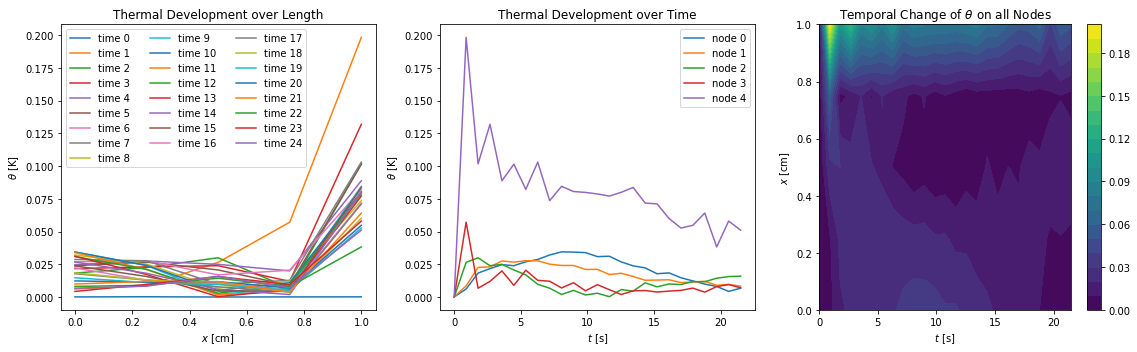

In [43]:
error = np.abs(pred - gt[0]) / gt[0]

plot_heat([100*error, gt[1], gt[2]])

The errors in the plots above are given in percent $[\%]$ and should be quite low, the highest errors are most likely localized at certain spots, where high gradients in the ground truth appear.

Of course this example is quite banal, the simulation runs fast and smoothly. Imagine though that you are creating a surrogate model for a much larger simulation that takes days or even weeks to run. If you want the results for a certain combination of parameters, an ANN can usually produce it in a matter of seconds. The images below, taken from [PAMM 2019](https://onlinelibrary.wiley.com/doi/abs/10.1002/pamm.201900470) show an example surrogate model for a complex simulation of function-perfusion processes in the human liver. The target here is the fat volume fraction $n^T$, that should follow a certain distribution in a healthy liver. Shown below is a FEM simulation of a multiscale and multiphase theory of porous media (TPM) model of a liver lobule.

<div>
<img src="liver_ann.png" width="900" align="middle" style="margin:50px 50px"/>
</div>

On the left is a comparison between a simulation result from the test set and an ANN prediction. A simulation took several minutes, while the ANN could produce $\sim 500$ predictions per second(!). To get the data set (2348 samples), several days of simulations had to be performed. Using such a surrogate system, it is possible to get real-time or near real-time simulations. The middle graph shows the mean and standard distribution of the error over the whole test set errors. The error was computed for each sample in the test set (and for each node), then the mean and standard deviation of these errors plotted on the finite element mesh. The orange arrow marks the node with the highest error. For this node, a comparison of the ANN-predicted results and the simulation results is shown on the right side.

---

## Conditional Variational Autoencoders (19 points)
We talked about variational autoencoders in the last lecture. They encode information much better and more "logically" than standard autoencoders. When using a standard VAE for compressing information, the mean and standard deviation (or variance) of a multivariate (usually Gaussian) distribution are produced in the code layer. When sampling from these, we don't know what we'll get in the end, although the outputs are related for adjacent samples from the latent space. A way to tackle this shortcoming is to use a *conditional* VAE. The condition is another variable that is fed into the network as an input and reproduced in the code layer, such that when this condition is fed in for a prediction, a sample belonging to the condition is drawn from the learnt distribution.

The foundation here is a Python version of the infamous [99 line topology optimization code](https://www.topopt.mek.dtu.dk/Apps-and-software/New-99-line-topology-optimization-code-written-in-MATLAB) originally written for Matlab. There are several Python implementations you can find on the net. Here, we use [this implementation](https://www.topopt.mek.dtu.dk/apps-and-software/topology-optimization-codes-written-in-python) optimized with sparse Choleski factorization. The input to it are, apart from geometry and load, and material parameters, the desired volume fraction, the penalty factor for calculating the compliance, the filter radius for mitigating checkerboarding (this happens because topology optimization uses gradient-based methods for discrete structures). 

The way to use a conditional autoencoder on such a problem is to use the volume fraction as the condition (or the other parameters too) and train the autoencoder on the results. In the end, you would then be able to choose a desired volume fraction and not only get a single result, but a seamlessly explorable set of results, sampled from adjacent latent space vectors. This would be extremely similar to what we've seen last lecture in the example for what General Motors did.

The code below sets everything up for creating the data. To save time, a dataset is available to be loaded below, so **you don't have to execute the following cell**. **It takes a long time to create the training data!**. For your own tests, change the cell below to a code cell to execute it.

# A 200 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
# Updated by Niels Aage February 2016
from __future__ import division
import numpy as np

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
import cvxopt ;import cvxopt.cholmod

def main(nelx,nely,volfrac,penal,rmin,ft):
    print("Minimum compliance problem with OC")
    print("ndes: " + str(nelx) + " x " + str(nely))
    print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
    print("Filter method: " + ["Sensitivity based","Density based"][ft])

    # Max and min stiffness
    Emin=1e-9
    Emax=1.0

    # dofs:
    ndof = 2*(nelx+1)*(nely+1)

    # Allocate design variables (as array), initialize and allocate sens.
    x=volfrac * np.ones(nely*nelx,dtype=float)
    xold=x.copy()
    xPhys=x.copy()

    g=0 # must be initialized to use the NGuyen/Paulino OC approach
    dc=np.zeros((nely,nelx), dtype=float)

    # FE: Build the index vectors for the for coo matrix format.
    KE=lk()
    edofMat=np.zeros((nelx*nely,8),dtype=int)
    for elx in range(nelx):
        for ely in range(nely):
            el = ely+elx*nely
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely
            edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])
    # Construct the index pointers for the coo format
    iK = np.kron(edofMat,np.ones((8,1))).flatten()
    jK = np.kron(edofMat,np.ones((1,8))).flatten()    

    # Filter: Build (and assemble) the index+data vectors for the coo matrix format
    nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
    iH = np.zeros(nfilter)
    jH = np.zeros(nfilter)
    sH = np.zeros(nfilter)
    cc=0
    for i in range(nelx):
        for j in range(nely):
            row=i*nely+j
            kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
            kk2=int(np.minimum(i+np.ceil(rmin),nelx))
            ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
            ll2=int(np.minimum(j+np.ceil(rmin),nely))
            for k in range(kk1,kk2):
                for l in range(ll1,ll2):
                    col=k*nely+l
                    fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                    iH[cc]=row
                    jH[cc]=col
                    sH[cc]=np.maximum(0.0,fac)
                    cc=cc+1
    # Finalize assembly and convert to csc format
    H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()    
    Hs=H.sum(1)

    # BC's and support
    dofs=np.arange(2*(nelx+1)*(nely+1))
    fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
    free=np.setdiff1d(dofs,fixed)

    # Solution and RHS vectors
    f=np.zeros((ndof,1))
    u=np.zeros((ndof,1))

    # Set load
    f[1,0]=-1
    # Initialize plot and plot the initial design
    #plt.ion() # Ensure that redrawing is possible
    #fig,ax = plt.subplots()
    #im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
    #interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
    #fig.show()
    
    loop=0
    change=1
    dv = np.ones(nely*nelx)
    dc = np.ones(nely*nelx)
    ce = np.ones(nely*nelx)
    while change>0.01 and loop<2000:
        loop=loop+1
        # Setup and solve FE problem
        sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
        K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
        # Remove constrained dofs from matrix and convert to coo
        K = deleterowcol(K,fixed,fixed).tocoo()
        # Solve system 
        K = cvxopt.spmatrix(K.data,K.row.astype(np.int),K.col.astype(np.int))
        B = cvxopt.matrix(f[free,0])
        cvxopt.cholmod.linsolve(K,B)
        u[free,0]=np.array(B)[:,0] 

        # Objective and sensitivity
        ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
        obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
        dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce

        dv[:] = np.ones(nely*nelx)
        # Sensitivity filtering:
        if ft==0:
            dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)
        elif ft==1:
            dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
            dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]

        # Optimality criteria
        xold[:]=x
        (x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)

        # Filter design variables
        if ft==0:   xPhys[:]=x
        elif ft==1:    xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
        
        # Compute the change by the inf. norm
        change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)

        # Plot to screen
        #im.set_array(-xPhys.reshape((nelx,nely)).T)
        #fig.canvas.draw()

        # Write iteration history to screen (req. Python 2.6 or newer)
        #print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
        #            loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))

    # Make sure the plot stays and that the shell remains    
    #plt.show()
    #input("Press any key...")
    return xPhys
    
#element stiffness matrix
def lk():
    E=1
    nu=0.3
    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
    return (KE)

def oc(nelx,nely,x,volfrac,dc,dv,g):
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)

    while (l2-l1)/(l1+l2)>1e-3:
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)
    
def deleterowcol(A, delrow, delcol):
    # Assumes that matrix is in symmetric csc form !
    m = A.shape[0]
    keep = np.delete (np.arange(0, m), delrow)
    A = A[keep, :]
    keep = np.delete (np.arange(0, m), delcol)
    A = A[:, keep]
    return A    

if __name__ == "__main__":
    # Default input parameters
    nelx=180#36
    nely=60#12
    volfrac=0.5
    rmin=0.2#3.4
    penal=2.0#2.0
    ft=1 # ft==0 -> sens, ft==1 -> dens
    
    inputs = []
    outputs = []
    
    ### This creates the actual training data
    for volfrac in np.arange(0.1, 0.9, 0.1):
        for penal in np.arange(2.8, 3.2, 0.1):
            for rmin in np.arange(4.0, 5.8, 0.1):
                inputs.append([nelx, nely, volfrac, penal, rmin, ft])
                outputs.append(main(nelx, nely, volfrac, penal, rmin, ft))
                
    input_array = np.array(inputs)
    output_array = -np.array(outputs) # values saved negatively by method above
    
    np.save("CVAE_inputs.npy", input_array)
    np.save("CVAE_outputs.npy", output_array)

    #import sys
    #if len(sys.argv)>1: nelx   =int(sys.argv[1])
    #if len(sys.argv)>2: nely   =int(sys.argv[2])
    #if len(sys.argv)>3: volfrac=float(sys.argv[3])
    #if len(sys.argv)>4: rmin   =float(sys.argv[4])
    #if len(sys.argv)>5: penal  =float(sys.argv[5])
    #if len(sys.argv)>6: ft     =int(sys.argv[6])

    #xPhys = main(nelx,nely,volfrac,penal,rmin,ft)
    
    print("Done. Created ", len(inputs), "samples.")


Let's load and take a look at the data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# labels are the volume fractions
y = np.load("/data/CVAE_inputs.npy")[:,2]  # 2nd column is volume fractions
# data is the results from the topology optimization
X = np.load("/data/CVAE_outputs.npy")

def plot_bridge(i):
    fig,ax = plt.subplots()
    
    print(f"Volume fraction: {y[i]}")
    im = ax.imshow(X[i].reshape((180,60)).T, cmap='gray_r')
    plt.axis('off')
    
    plt.show()
    
interact(plot_bridge, i=(0, X.shape[0]-1))

interactive(children=(IntSlider(value=199, description='i', max=399), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bridge(i)>

With the data set up, we can start with the machine learning part. The data labels are the volume fractions, but they're really close numerically (0.1, 0.2, 0.3, ...), which makes the network difficult to train. A good way to help here is to use *one-hot encoding*, which we can use since there's a fixed number of volume fractions we trained for. Earlier, we used the `one_hot` function to do so. Below, we'll use the `to_categorical` function instead for some variety, but it works in a similar way.

Create a variable called `y_oh` which contains the one-hot-encoded labels `y` after multiplying them with 10 and subtracting 1. The latter is necessary because `to_categorical` expects integers starting from 0.

Below that, create training and test sets called `X_train`, `X_test`, `y_train`, `y_test`, with a test split of 0.1. It is also a very good idea to *shuffle* your data, since otherwise the test split will cut off data that the network won't see at all. You can use any way you like, but the easiest way is to use `scikit-learn`'s `train_test_split` function.

In [2]:
#import warnings
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

#warnings.filterwarnings('ignore')

# create y_oh that containes one-hot-encoded labels here
### BEGIN SOLUTION
y_oh = to_categorical(10*y-1, num_classes=8)
### END SOLUTION

# create training and test sets here
### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.1, shuffle=True)
### END SOLUTION

# see whether everything makes sense:
print(y_train)

print(X_train.shape)
print(y_train.shape)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(360, 10800)
(360, 8)


In [3]:
for i in range(20):
    assert y_oh[i,int(10*y[0]-1)] == 1
assert X_train.shape == (360, 10800)
assert y_train.shape == (360, 8)

Below, you'll find some more setup for the actual model itself. We need to decide on a latent space size and the encoder as well as decoder hidden space dimensions and the activation used. We'll use `ReLU` here, although `LeakyReLU` would likely work better. You can also see how you could change some parameters for optimizers that are already implemented in keras.

In [4]:
# we'll later sample ϵ as a batch
# needs to be a divisor of the total number of training data
batch_size = 1

# feature and label dimensions for easier reference
n_x = X_train.shape[1]
n_y = y_train.shape[1]

# size of the latent space without condition
n_z = 2 

# dimensions of layers in the autoencoder
encoder_dim = 512     # dim of encoder hidden layer
decoder_dim = 512     # dim of decoder hidden layer
decoder_out_dim = n_x # dim of decoder output layer
activation = 'relu'

# optimizers can be adjusted if desired
optimizer = Adam(lr=0.001)


print(n_x)
print(n_y)

10800
8


There's still some more setting up we need to do. Unfortunately, for our endeavor we have to do quite a lot of the model building manually. Fill in the blanks below:

In [5]:
K.clear_session()

# this is necessary due to a bug
from tensorflow.compat.v1 import disable_eager_execution
disable_eager_execution()

# define the input layer for the encoder below, called "enc_in"
# use an "Input" layer like we've seen before, with the appropriate
# shape. The inputs here are just for the features in our X data set
### BEGIN SOLUTION
enc_in = Input(shape=(n_x,))
### END SOLUTION

# create an Input layer for the labels we're going to feed to the 
# network as well. Call the layer "label" and assign it an 
# "Input" layer with size the same as the y_train labels
### BEGIN SOLUTION
label = Input(shape=(n_y,))
### END SOLUTION

# concatenate both to the final input layer
inputs = concatenate([enc_in, label])

# add hidden encoder layer
encoder_h = Dense(encoder_dim, activation=activation)(inputs)

# for the mean and variances, we need two fully-conected (Dense) layers
# create a Dense layer called "μ" with a number of neurons that reflects
# our latent space size, and linear activation, then place "(encoder_h)" 
# at the end, so that it becomes attached to the hidden encoder layer
# do the same thing for Σ, the lines should look exactly the same
### BEGIN SOLUTION
μ = Dense(n_z, activation='linear')(encoder_h)
Σ = Dense(n_z, activation='linear')(encoder_h)
### END SOLUTION

# function for shifting the sampled ϵ to the actual distribution
def sample_z(args):
    μ, Σ = args
    ϵ = K.random_normal(shape=(batch_size, n_z), mean=0.0, stddev=1.0)
    return μ + K.exp(Σ / 2) * ϵ


# sampling latent space by using the above function in a Lambda layer
z = Lambda(sample_z, output_shape = (n_z, ))([μ, Σ])

# merge latent space with label
zc = concatenate([z, label])
print (zc.shape)

# build decoder layers
decoder_h = Dense(decoder_dim, activation=activation)
# sigmoid activation for pixel-wise comparison
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
# put together
h_p = decoder_h(zc)
outputs = decoder_out(h_p)

(None, 10)


In [6]:
assert enc_in.shape[0] == None
assert label.shape[0]  == None
assert μ.shape[0] == None
assert Σ.shape[0] == None
assert "input" in str(enc_in)
assert "input" in str(label)
assert "dense" in str(μ)
assert "dense" in str(Σ)


We have to define the loss functions ourselves. Recall from the last lecture that it had two parts, the KL-loss and the reconstruction loss (why are we using binary crossentropy here?).

In [7]:
# losses have to be custom-built
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(Σ) + K.square(μ) - 1. - Σ, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(Σ) + K.square(μ) - 1. - Σ, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

Now it's time to actually build the autoencoder. Combining the layers is done below. Compile the model with optimizer `optimizer` initialized before, `vae_loss` as the objective function, and the `KL_loss` and `recon_loss` as metrics. 

Note that the latter two are *not* suitable as metrics to determine the goodness of the fit (since we're using their sum as the loss function), but they do give us some information about which part of the loss is improving when. Especially for the Kullback-Leibler divergence it's important to get it to a sufficiently low level. In a good run, the latent space distribution should be Gaussian. We'll visualize this in a moment.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10800)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 10808)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          5534208     concatenate[0][0]            

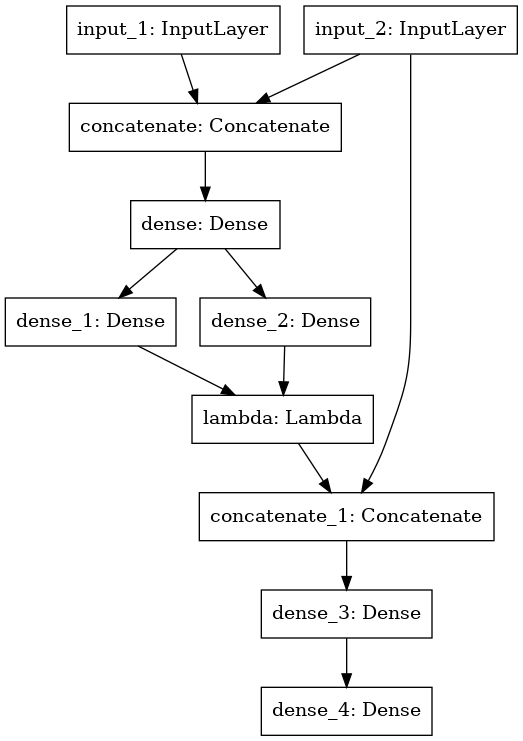

In [8]:
from tensorflow.keras.utils import plot_model

# build the whole thing
cvae = Model([enc_in, label], outputs)

# get handles for encoder
encoder = Model([enc_in, label], μ)

# and decoder
d_in = Input(shape=(n_z+n_y,))
d_h = decoder_h(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

### BEGIN SOLUTION
cvae.compile(optimizer=optimizer, loss=vae_loss, metrics = [KL_loss, recon_loss])
### END SOLUTION

cvae.summary()
plot_model(cvae)

In [14]:
assert "adam" in str(cvae.optimizer)
assert "vae_loss" in str(cvae.loss)
assert len(cvae.metrics) == 2

These are quite a few parameters, but we can already achieve useful results with a little bit of training. We'll use a custom callback here to stop the training as soon as the KL divergence is below 5.5 (below 1 would be the better goal, but time is constrained here). 

Fit the model to the input data `[X_train, y_train]` (images AND labels) to the target `X_train` (only the images!), with a `batch_size` of $4$, a `validation_split` of $0.1$ and for $200$ `epochs`. Additionally provide the `custom_callback` for early stopping and visualizing the training state. Save the results in a variable called `cvae_hist`.

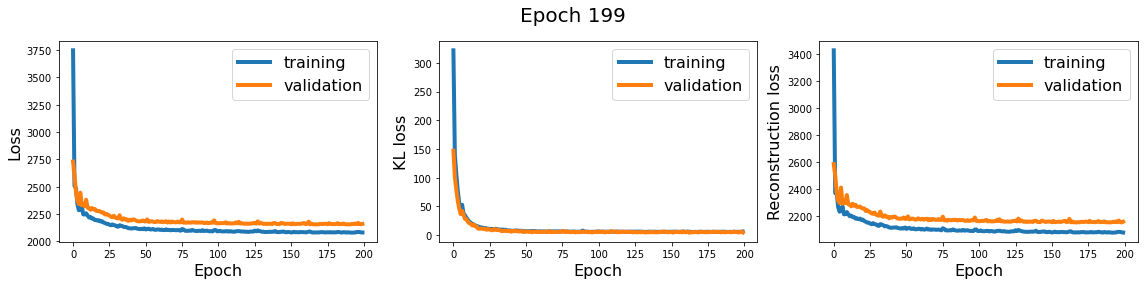

324/324 [==============================] - 2s 7ms/sample - loss: 2081.3741 - KL_loss: 6.1356 - recon_loss: 2075.2380 - val_loss: 2159.8481 - val_KL_loss: 4.8283 - val_recon_loss: 2155.0195


In [9]:
%matplotlib inline
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.KL_losses = []
        self.val_KL_losses = []
        self.recon_losses = []
        self.val_recon_losses = []
        

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs["loss"])
        self.val_losses.append(logs["val_loss"])
        self.KL_losses.append(logs["KL_loss"])
        self.val_KL_losses.append(logs["val_KL_loss"])
        self.recon_losses.append(logs["recon_loss"])
        self.val_recon_losses.append(logs["val_recon_loss"])
        
        clear_output(wait=True)
        
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        
        fig.suptitle(f"Epoch {epoch}", fontsize=20)
        
        axs[0].plot(self.x, self.losses, lw=4, label="training")
        axs[0].plot(self.x, self.val_losses, lw=4, label="validation")
        axs[0].legend(fontsize=16)
        axs[0].set_xlabel("Epoch", fontsize=16)
        axs[0].set_ylabel("Loss", fontsize=16)
        #axs[0].set_yscale("log")
        
        axs[1].plot(self.x, self.KL_losses, lw=4, label="training")
        axs[1].plot(self.x, self.val_KL_losses, lw=4, label="validation")
        axs[1].legend(fontsize=16)
        axs[1].set_xlabel("Epoch", fontsize=16)
        axs[1].set_ylabel("KL loss", fontsize=16)
        #axs[1].set_yscale("log")
        
        axs[2].plot(self.x, self.recon_losses, lw=4, label="training")
        axs[2].plot(self.x, self.val_recon_losses, lw=4, label="validation")
        axs[2].legend(fontsize=16)
        axs[2].set_xlabel("Epoch", fontsize=16)
        axs[2].set_ylabel("Reconstruction loss", fontsize=16)
        #axs[2].set_yscale("log")
        
        axs[1].legend(fontsize=16)
        
        plt.tight_layout()
        plt.show()
        

        # recall the early stopping mechanism from assignment 06
        # set the model to stop_training=True when the 
        # KL divergence is lower than 5
        ### BEGIN SOLUTION
        if self.KL_losses[-1] < 5.5: 
            print(f"KL loss < 5.5, stopping training early at epoch {epoch}")
            self.model.stop_training = True
        ### END SOLUTION
        
custom_callback = CustomCallback()


### BEGIN SOLUTION
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=4, validation_split=0.1, epochs=200, callbacks=[custom_callback])
### END SOLUTION

In [14]:
#assert cvae_hist.history['loss'][-1] < cvae_hist.history['loss'][-3]
assert cvae_hist.history['loss'][-1] < 2100
assert cvae_hist.history['KL_loss'][-1] < 5.5



AssertionError: 

If the KL divergence isn't below 6, you can just rerun the training until it works. We can plot the distribution of samples in the latent space by plotting the outputs of the encoder and assigning colors according to the labels we fed it. 

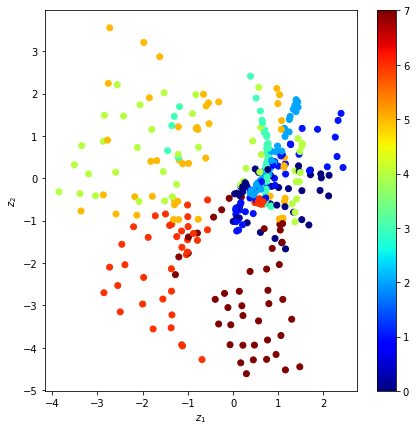

In [11]:
# produce encoded latent space representations of the inputs
z_train = encoder.predict([X_train, y_train])
# convert to numpy array
encodings = np.asarray(z_train)
# reshape to get 360 samples of 2D latent space vectors
encodings = encodings.reshape(X_train.shape[0], n_z)

# create y_labels that contains the actual digits
y_labels = np.argmax(y_train, axis=1)

# plot
plt.figure(figsize=(7, 7))

plt.scatter(encodings[:, 0], encodings[:, 1], c=y_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.show()

For such a low amount of training, the latent space above won't look Gaussian much. More training, more samples and better network architectures should fix that, but we can already work a bit with what we got here. If the training was stopped too early, you would see small clusters of each sample variant at different points. Later, they build up to lines. A good latent space is spread out as much as possible.

Let's explore the latent space around some point a bit:

In [12]:
# constructs latent space vector, such that the first n_z components
# are the latent vector space components and the rest is the 
# one-hot-encoded condition
def construct_latvec(volfrac, z = None):
    out = np.zeros((1, n_y + n_z))
    out[:, volfrac + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
# test the construct_latvec function
print(construct_latvec(3, [0.1, 0.1]))    
plt.figure(figsize=(3, 3))

def plot_number(volfrac_x_10=4, ae1=0, ae2=0, save=False):
    plt.cla()
    im = -decoder.predict(construct_latvec(volfrac_x_10-1, [ae1,ae2])).reshape(180,60).T
    plt.imshow(im, cmap = plt.cm.gray)
    plt.axis('off')
    plt.show()
    print("Real volume fraction: ", np.sum(-im)/(180*60))
    if save:
        plt.savefig(f"cvae_bridge_{volfrac_x_10}_{ae1}_{ae2}.pdf")
    
interact(plot_number, volfrac=(0, 7), ae1=(-4.0, 4.0, 0.2), ae2=(-4.0, 4.0, 0.2), save=[True, False])

[[0.1 0.1 0.  0.  0.  1.  0.  0.  0.  0. ]]


<Figure size 216x216 with 0 Axes>

interactive(children=(IntSlider(value=4, description='volfrac_x_10', max=12, min=-4), FloatSlider(value=0.0, d…

<function __main__.plot_number(volfrac_x_10=4, ae1=0, ae2=0, save=False)>

You should see that the components control the weight distribution inside the domain. One component creates or removes support structures, the other component sort of "rotates" the triangles, leading to different attack points for the support structures. This way, you can seamlessly change between different expressions of the same optimized bridge for some desired volume fraction.  

Note that when the components are chosen higher or lower than the latent space dimension (compare to above), "bleeding" occurs and the volume fraction won't be obeyed anymore. The results would likely be much better if extreme cases like volume fractions of 0.1, 0.2, 0.8, 0.9 were not included in the dataset, since in those cases mass is difficult to shift around in a meaningful way.

We can plot a variety of different latent space vectors for a given condition to see a few eamples at once:

In [13]:
%matplotlib notebook

# number of images in both dimensions
sides = 5
#iterate from -max_z to max_z in all dimensions of the latent space
max_z1 = 2
max_z2 = 2


def plot_numbers(number=4, save=False):
    fig = plt.figure(figsize=(12,12))
    
    img_it = 0
    for i in range(0, sides):
        z1 = (((i / (sides-1)) * max_z1)*2) - max_z1
        for j in range(0, sides):
            z2 = (((j / (sides-1)) * max_z2)*2) - max_z2
            z = [z1, z2]
        
            vec = construct_latvec(number, z)
            decoded = decoder.predict(vec)
            
            plt.subplot(sides, sides, 1 + img_it)
            img_it +=1
            plt.imshow(-decoded.reshape(180, 60).T, cmap = plt.cm.gray)
            plt.axis('off')
    #plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=.05)
    if save:
        plt.savefig("opt_" + str(number) + "_" + str(sides) + "x" + str(sides) + ".pdf")
    plt.show()

interact(plot_numbers, number=(0,8), save=[True,False])

interactive(children=(IntSlider(value=4, description='number', max=8), Dropdown(description='save', index=1, o…

<function __main__.plot_numbers(number=4, save=False)>

---